# Predicting Customer Churn

## 1. Introduction

Churn prediction is one of the most important big data challenges in business analytics. Churn is defined as an existing customer stops or cancels services or prodcuts with a company. Churn rate, the percentage of customers churn given a time frame, is an important metric for a growing business. 

The datasets are obtained from the Kaggle challenge [*Telco Customer Churn*](https://www.kaggle.com/c/customer-churn-prediction-2020/overview), predicting whether a customer will change telecommunications provider. There are two datasets, training and test sets. However, the test set is a submission set that does not have outcome variable. Therefore, we will use the training set to train and validate the algorithm.

### 1.1 Load data

In [2]:
import pandas as pd
train = pd.read_csv("/Users/panyujun/Documents/Portfolio/customer_churn/data/train.csv")
test = pd.read_csv("/Users/panyujun/Documents/Portfolio/customer_churn/data/test.csv") 

Now let's take a look at the sizes of both datasets.

In [3]:
train.shape

(4250, 20)

In [4]:
test.shape

(750, 20)

Though both datasets contain 20 variables, the test set does not have the **churn** variable, which is the outcome variable. Instead, it contains the **id** variable that Kaggle uses to evaluate the submission.

Now, let's have a glimpse of the data.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
state                            4250 non-null object
account_length                   4250 non-null int64
area_code                        4250 non-null object
international_plan               4250 non-null object
voice_mail_plan                  4250 non-null object
number_vmail_messages            4250 non-null int64
total_day_minutes                4250 non-null float64
total_day_calls                  4250 non-null int64
total_day_charge                 4250 non-null float64
total_eve_minutes                4250 non-null float64
total_eve_calls                  4250 non-null int64
total_eve_charge                 4250 non-null float64
total_night_minutes              4250 non-null float64
total_night_calls                4250 non-null int64
total_night_charge               4250 non-null float64
total_intl_minutes               4250 non-null float64
total_intl_calls           

In [6]:
train.head(4)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


As we can see, variables `state`, `area_code`, `international_plan`, `voice_mail_plan` and `churn` are categorical variables and their values are strings, which may need to be recoded depends on the machine learning alghrithm we choose.

## 2. Feature Selection and Feature Engineering

### 2.1 Do we need ID variables?

We have a couple of ID variables here: `state` and `area_code`. They are geographical variables that contains dozens of string values. One way we can encode these variables is the **one-hot encoding**, that make each unique value a binary variable. However, in this case, they are computing expensive. We may come back later and see if it will improve the overall prediction later on.

For now, we will drop them.

In [7]:
train = train.drop(['state', 'area_code'], axis=1)

### 2.2 `voice_mail_plan` and `number_vmail_messages`

The first pair of variables catched my eyes are `voice_mail_plan` and `number_vmail_messages`. They clearly convey the same information. Although one is a binary variable and the other one is numeric. Let's take a look at a 2 by 2 contingency table:

In [8]:
pd.crosstab(train.voice_mail_plan, train.number_vmail_messages)

number_vmail_messages,0,4,6,8,10,11,12,13,14,15,...,42,43,44,45,46,47,48,49,50,52
voice_mail_plan,,,,,,,,,,,,,,,,,,,,,
no,3138,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yes,1,1,2,2,4,2,10,3,7,12,...,17,13,7,10,7,4,4,3,2,1


Except for the one observation that seems like an error, for all the customers who does not have a voice mail plan, their number of voice mail messages is 0. Let's make the correction here. 

In [9]:
train.loc[train.number_vmail_messages == 0, 'voice_mail_plan'] = 'no'

### 2.3 Total minutes, calls and charge during the day, in the evening and at night

I couldn't help noticing the 9 variables correspoinding to the total minutes, calls and charge during the day, in the evening and at night: 

`total_day_minutes`, `total_day_calls`,	`total_day_charge`, `total_eve_minutes`,	`total_eve_calls`,	`total_eve_charge`,	`total_night_minutes`, `total_night_calls`,	`total_night_charge`

Oh, don't forget about the `total_intl_minutes`, `total_intl_calls`, `total_intl_charge`

I understand how they can influence the customers' behavior but do we really need to be that specific? Let's do some digging.

First, we should decide if we can keep all of the variables. We are very likely to drop or recode them. Let's check out the correlations:

In [10]:
train.corr()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
account_length,1.000000,-0.006626,-0.001612,0.023002,-0.001613,-0.010326,0.005535,-0.010322,-0.009916,-0.001846,-0.009942,0.004539,0.013690,0.004494,0.001002
number_vmail_messages,-0.006626,1.000000,0.002000,-0.006920,0.001994,0.010725,0.003593,0.010736,0.018308,0.001977,0.018300,0.005220,0.006585,0.005249,-0.015303
total_day_minutes,-0.001612,0.002000,1.000000,0.000747,1.000000,-0.013248,0.005986,-0.013258,0.010049,-0.004812,0.010036,-0.021369,0.003859,-0.021291,-0.002925
total_day_calls,0.023002,-0.006920,0.000747,1.000000,0.000751,0.008661,0.003739,0.008663,0.002206,-0.004815,0.002200,0.008834,0.009377,0.008909,-0.015845
total_day_charge,-0.001613,0.001994,1.000000,0.000751,1.000000,-0.013247,0.005985,-0.013257,0.010053,-0.004816,0.010040,-0.021374,0.003853,-0.021296,-0.002932
total_eve_minutes,-0.010326,0.010725,-0.013248,0.008661,-0.013247,1.000000,0.003101,1.000000,-0.014018,0.011973,-0.014031,-0.003509,0.012239,-0.003460,-0.010063
total_eve_calls,0.005535,0.003593,0.005986,0.003739,0.005985,0.003101,1.000000,0.003120,0.008425,-0.011929,0.008441,-0.013096,0.004949,-0.013145,0.006956
total_eve_charge,-0.010322,0.010736,-0.013258,0.008663,-0.013257,1.000000,0.003120,1.000000,-0.014022,0.011971,-0.014035,-0.003512,0.012239,-0.003463,-0.010071
total_night_minutes,-0.009916,0.018308,0.010049,0.002206,0.010053,-0.014018,0.008425,-0.014022,1.000000,0.023815,0.999999,-0.000113,-0.024280,-0.000047,-0.013771
total_night_calls,-0.001846,0.001977,-0.004812,-0.004815,-0.004816,0.011973,-0.011929,0.011971,0.023815,1.000000,0.023798,0.001093,0.003851,0.001054,-0.008893


We can see that the pairs of `total_day_charge` and `total_day_calls`, `total_night_charge` and `total_night_minutes`, `total_intl_charge` and `total_intl_minutes` are highly correlated, and we must drop either one variable in the pairs. 

Now let's check if the times of the day or whether it is an international call or not can really influence the churn rate.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

variables = ['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes',
            'total_day_calls', 'total_eve_calls', 'total_night_calls', 'total_intl_calls',
             'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge' 
            ]

In [12]:
xlabs = ['day', 'eve', 'night', 'intl', '', '', '', '', '', '', '', '']

ylabs = ['minutes', '','','',
         'calls', '','','',
         'charge','','','',]

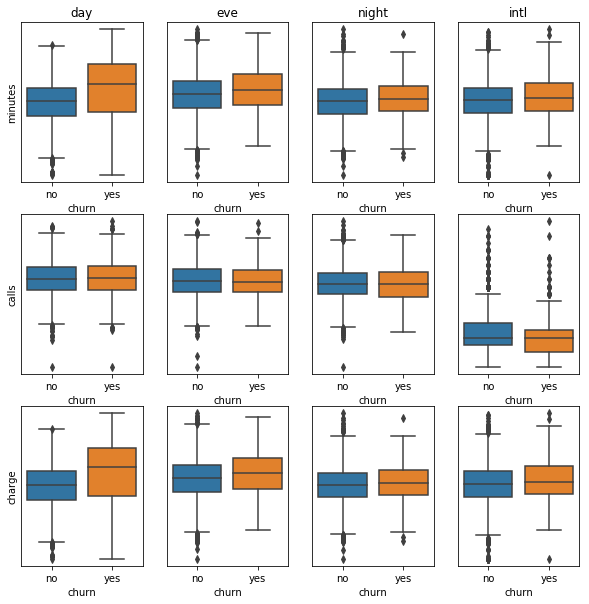

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,10))
i = j = 0
for n in range(12):
    g = sns.boxplot(x='churn', y=variables[n], data=train, ax=axs[i][j])
    g.set_title(xlabs[n])
    g.set_ylabel(ylabs[n])
    g.set_yticks([])
    j += 1
    if j>3:
        i += 1; j = 0

As we can see here, for the number of calls, the times of days does not impact the churn rate. However, the total minutes and total charge are highly dependent on which times of the days. One important question to be asked: does the company charge different rates per minute based on the time of the day?

Let's do some experimentation here. First, calculate the cost per minute by different times of the day and compare the rates.

In [14]:
train['day_charge_per_min'] = train['total_day_charge']/train['total_day_minutes']
train['eve_charge_per_min'] = train['total_eve_charge']/train['total_eve_minutes']
train['night_charge_per_min'] = train['total_night_charge']/train['total_night_minutes']
train['intl_charge_per_min'] = train['total_intl_charge']/train['total_intl_minutes']
new_vars = ['day_charge_per_min', 'eve_charge_per_min', 'night_charge_per_min',
           'intl_charge_per_min']

In [15]:
np.around([train.day_charge_per_min.mean(), train.eve_charge_per_min.mean(), 
           train.night_charge_per_min.mean(), train.intl_charge_per_min.mean()], 3)

array([0.17 , 0.085, 0.045, 0.27 ])

Well I'm afraid they do charge different rates depending on the times of the day. However, does these rates differ by each customer, i.e. does the rates influence churn rates alone?

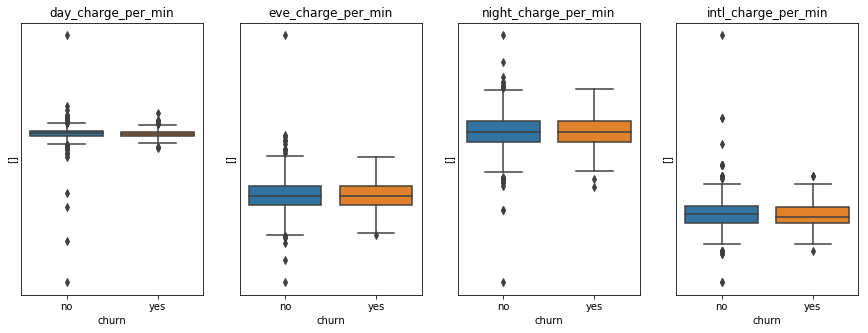

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
i = j = 0
for n in range(4):
    plt.subplot(1,4,n+1)
    g = sns.boxplot(x='churn', y = new_vars[n], data=train)
    g.set_title(new_vars[n])
    g.set_ylabel([])
    g.set_yticks([])
    j += 1
    

So the different rates does not influence churn rates alone. It's more about the total usage and total cost that determines the churn rate. Therefore, we will drop the newly created variables.

In [17]:
train = train.drop(new_vars, axis=1)

In [18]:
train['total_call'] = train['total_day_calls'] + train['total_eve_calls'] + train['total_night_calls']
train['total_minutes'] = train['total_day_minutes'] + train['total_eve_minutes'] + train['total_night_minutes']
train['total_charge'] = train['total_day_charge'] + train['total_eve_charge'] + train['total_night_charge']

I'm a little hesitant to keep both `total_call` and `total_charge`. They both indicate usage and there's a high chance that they will be highly correlated.

In [19]:
train[['total_call', 'total_charge']].corr()

,total_call,total_charge
total_call,1.000000,0.011061
total_charge,0.011061,1.000000


Great! Let's keep both variables and let the algorithm decides.

### 2.3 Drop variables 

We have now done a exhausive examination of all the variables and it's time to drop additional variables.

In [20]:
variables_to_drop = ['number_vmail_messages',
                     'total_day_minutes',
                     'total_day_calls',
                     'total_day_charge',
                     'total_eve_minutes',
                     'total_eve_calls',
                     'total_eve_charge',
                     'total_night_minutes',
                     'total_night_calls',
                     'total_night_charge',
                     'total_intl_minutes',
                     'total_intl_calls']
train = train.drop(variables_to_drop, axis=1)

### 2.4 Recoding binary variables

Most classifiers in python do not work with strings. Therefore, a binary variable should be recoded as 0 and 1.

In [21]:
train['international_plan'] = train['international_plan'].replace({'no':0, 'yes':1}) 
train['voice_mail_plan'] = train['voice_mail_plan'].replace({'no':0, 'yes':1})

##### Transform test set as well

In [22]:
test = test.drop(['state', 'area_code'], axis=1)
test.loc[test.number_vmail_messages == 0, 'voice_mail_plan'] = 'no'
test['total_call'] = test['total_day_calls'] + test['total_eve_calls'] + test['total_night_calls']
test['total_minutes'] = test['total_day_minutes'] + test['total_eve_minutes'] + test['total_night_minutes']
test['total_charge'] = test['total_day_charge'] + test['total_eve_charge'] + test['total_night_charge']
test = test.drop(variables_to_drop, axis=1)

In [92]:
test['international_plan'] = test['international_plan'].replace({'no':0, 'yes':1}) 
test['voice_mail_plan'] = test['voice_mail_plan'].replace({'no':0, 'yes':1})

## 3. Train a Random Forest Model

### 3.1 Split training and testing sets

To train the model and test the performance of the model, we need to first split the data into training and test set. Most people use a 80/20 proportion to split the dataset. However, in this case, I want to be more generous and use a 70/30 proportion. One important reason is that most churn datasets are unbalanced, meaning there are more customers who did not churn, compared to customers who do, so I want to allow sufficient samples to detect churning customers. 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = train.drop('churn', axis=1)
y = train['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### 3.2 Train Model

After spliting the dataset, it's time to fit the model. I choose the argument `boostrap` to be tree, which means that the Random Forest (RF) model will sample with replacement, which allows a bit more randomness in our results. We will likely see an improvement of performance in the test set.

In [24]:
clf = RandomForestClassifier(bootstrap=True, random_state = 1, oob_score=True)
clf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

### 3.3 Evaluate Model Performance with Different Metrics

Let's check accuracy:

In [25]:
print(clf.score(X_test, y_test))

0.9576470588235294


Wonderful! 95.76% of accuracy in the test set is great! However, remember earlier that we mentioned how the dataset is unbalanced?

In [26]:
from statistics import  mean
round(mean(train.churn == "yes"), 2)

0.14

Only 14% of the data consists of customers who churn. We may need to find another statistics or metrics that evaluate our performance. We can turn to **sensitivity** or **recall_score**, i.e. for all the customer who churn, what is the proportion that they are accuratly detected? 

We can examine this from the confusion matrix, or use the imbeded function from sklearn.

In [65]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred, labels=['no','yes']))

[[1072    8]
 [  46  149]]


In [41]:
from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred, average="binary", pos_label='yes'))

0.764102564102564


We have a 76.41% of sensitivity, which is a very satisfying performance.

We are also interested in using a single metric to evaluate both accuracy and sensitivity. F1 score is calculated as the following:

$2 \times{\frac{precision \bullet recall}{precision + recall}}$

In [29]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred, average="binary", pos_label="yes"))

0.8465909090909091


The F1 score is a value between 0 and 1, and the higher the F1 score, the better the performance. We have achieved a 0.85, which is also a satisfying performance.

Another imbeded metric of RF with boostrap sampling is that it will calculate Out-of-Bag (OOB) error for you. When sampling with replacement, some observations are not selected into samples to be fit with the model. If you want to save time and skip a few lines of coding to split the training and test sets, or do cross validation, OOB error is easily available. As we can see below, 0.96 OOB error is a high performance.

In [30]:
clf.oob_score_

0.9589915966386554

### 3.4  Interpretation: Variable Importances

Many people would consider RF as hard to interpret. Indeed, we don't exactly know how each variable's role in leading to final output, considering the amount of randomness or variation involved in the process. For example, there are as many as 500 trees are fitted, and only a random subset of variables were considered at each split. 

However, RF has another important feature, variable importances, that can gives us some insight of how each variable weights in the decision process. It is usually measured based on how much the accuracy or impurity (gini) decreases when the variable is excluded. 

In [31]:
importances = clf.feature_importances_

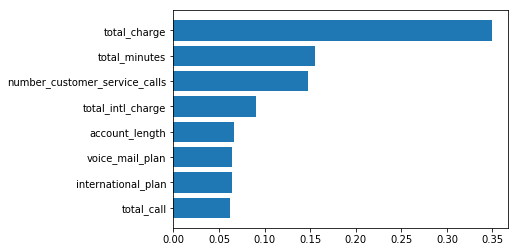

In [32]:
sorted_index = np.argsort(importances)
labels = X_train.columns[sorted_index]

plt.barh(range(X_train.shape[1]), importances[sorted_index], tick_label=labels)
plt.show()

We can see that `total_charge` and `total_minutes` are top 2 important indicators of churning. It tells us that charge and usage are important factor when customers decide to churn. The third most important variable is `number_customer_service_calls`, which is an indicator of the service quality or customer satisfaction. 

### 3.5 Tuning Hyperparameters

We have achieved a great performance so far by fitting a RF model. However, there's still room for improvement. A `hyperparameter` or its value constrols an algorithm's learning process. There are a couple of interesting hyperparameter in a RF model:

* `n_estimators`: Number of trees

* `criterion`: metrix used for a split

* `max_features`: Number of features for best split

* `max_depth`: Max depth of trees

* `min_sample_splits`: Minimum samples to split node

* `bootstrap`: Whether Boostrap samples are used

We can see a complete list of hyperparameters here:

In [33]:
clf.get_params().keys()
#clf.get_params()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

We will do a grid search, that fits a RF model on all possible comibinations of the prspecified values of each hyperparameter and select the best performing model. While most people would use precision or accuracy as the deciding metric, I will use F1 score here. 

First let's specified the possible values of the hyperparameters:

In [34]:
from sklearn.model_selection import GridSearchCV

# Create the hyperparameter grid
param_grid = {"n_estimators": [100, 300, 500],
              "max_depth": [3, None],
              "max_features": ['auto', 'sqrt', 'log2'],
              "min_samples_split": [20, 40, 50]}

In [45]:
# initiated the grid search function
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average="binary", pos_label='yes')

In [46]:
grid_search = GridSearchCV(clf, param_grid, scoring = f1)

In [47]:
# conduct the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(oob_score=True, random_state=1),
             param_grid={'max_depth': [3, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [20, 40, 50],
                         'n_estimators': [100, 300, 500]},
             scoring=make_scorer(f1_score, average=binary, pos_label=yes))

Let's check out the best combination of parameters:

In [48]:
print(grid_search.best_params_)

{'max_depth': None, 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 300}


Use the best parameters to refit the model:

In [55]:
clf_opt = RandomForestClassifier(bootstrap=True, random_state = 1, oob_score=True,
                                min_samples_split = 20, n_estimators = 300)

In [56]:
clf_opt.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=20, n_estimators=300, oob_score=True,
                       random_state=1)

### 3.6 Final Model Comparison with ROC

Now we have finished with hyperparameter tuning and grid search. It's time to compare the original model and the best performance model selected by grid search.

In [61]:
y_pred_opt = clf_opt.predict(X_test)

In [71]:
pd.DataFrame({'precision': [clf.score(X_test, y_test), clf_opt.score(X_test, y_test)],
'recall': [recall_score(y_test, y_pred, average="binary", pos_label='yes'),
recall_score(y_test, y_pred_opt, average="binary", pos_label='yes')],
'f1':[f1_score(y_test, y_pred, average="binary", pos_label="yes"),
f1_score(y_test, y_pred_opt, average="binary", pos_label="yes")],
'oob_score': [clf.oob_score_, clf_opt.oob_score_]}, index = ['original', 'best_selected'])

,precision,recall,f1,oob_score
original,0.957647,0.764103,0.846591,0.958992
best_selected,0.958431,0.758974,0.848138,0.958992


It looks like the hyperparameter tuning did not yield significant improvement in precision and F1 score. Surprisingly, the recall score is smaller than the original model. In this case, we will choose original model as our final predicting model. 

#### ROC

One last comparison will be the (Receiver operating characteristic) ROC curve and area under the curve (AUC). ROC curve plots false positive rate against true positive rate all classification thresholds. We are looking for a model that yields small false positive rate while also gives us large true positive rate. Therefore, the higher the AUC, the better. 

In [78]:
from sklearn.metrics import roc_curve

# original model
y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label="yes")

# model selected by grid search
y_pred_opt_prob = clf_opt.predict_proba(X_test)[:, 1]
fpr_opt, tpr_opt, thresholds_opt = roc_curve(y_test, y_pred_opt_prob, pos_label="yes")

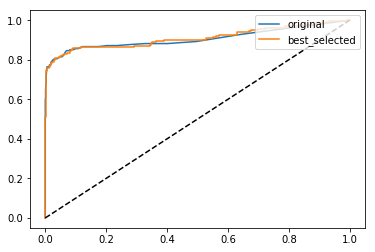

In [82]:
plt.plot(fpr, tpr, label = 'original')
plt.plot(fpr_opt, tpr_opt, label = 'best_selected')
plt.plot([0, 1], [0, 1], "k--")

plt.legend(loc="upper right")
plt.show()

Let's compare the AUC between 2 models:

In [84]:
from sklearn.metrics import roc_auc_score
[roc_auc_score(y_test, y_pred_prob), roc_auc_score(y_test, y_pred_opt_prob)]

[0.9067830009496676, 0.9102659069325737]

The latter model performs slightly better in terms of AUC but the margin is not high enough for us to change the predicting model.

# 4. Make the predicting and submit to Kaggle!

It's time to make the predicting and submit the submission dataset to Kaggle using our choosen model.

In [93]:
X_test_k = test.drop('id', axis=1)

In [94]:
y_pred_k = clf.predict(X_test_k)

In [109]:
submission = pd.DataFrame({
    'id': test.id.tolist(),
    'churn': y_pred_k.tolist()
})

In [111]:
submission.to_csv (r'/Users/panyujun/Documents/Portfolio/customer_churn/data/submission.csv', index = False, header=True)

# 5. Recap

What do we learn from this exercise:

1. Cleaning data, feature selection and feature engineering is probably much more important than just fitting the model. Domain knowledge is the key.

2. It's important to select the right metrics, which largely depends on business needs. 

3. Tuning hyperparameter might not give you the marginal yield you expected. 